<div class="usecase-title"><padding-left: 15px><padding-bottom: 10px><padding-top: 10px>
    <padding-right: 15px>
    <background-color: #Black><p style="color:#14a38e;"><b>Pedestrains Counts and Bus-stops</b></p></div>

<div class="usecase-authors"><b>Preprocessing by: </b>Shilpa Sharma</div>
<div class="usecase-authors"><b>Analysis by: </b>Alison Collins</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Preprocessing, Data Analysis, Machine Learning</div>
</div>

<div class="usecase-section-header">Scenario</div>

1. As a city planner, when considering bus stop locations and pedestrian safety, I want to identify if there is a relationship between bus stop locations and pedestrian numbers.

2. As a business owner, I want to visualise the potential of foot traffic against bus stops, to assist in decision making of new business locations.


<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Import libraries, check for missing /null values in order to have a clean dataset
- Data visualisation by using matplotlib, seaborn, Geopandas
- Convert between Geodataframes and dataframes
- Use Geopandas to take subsamples of Geodataframes
- Allow user input
- Resample dataframes using date_time
- Mapping with folium incuding custom markers
- Oversampling, Undersampling and bootstrap approaches for imbalanced data classes
- Predictive modelling with Logistic Regression and Random Forest
- Understand results of confusion matrix, accuracy score and classification reports

<div class="usecase-section-header">Background</div>

Imagine the vibrant city of Melbourne grappling with the dual challenges of urban mobility and pedestrian flow. As the city evolves, so does the need for a transit system that not only efficiently moves people but also integrates seamlessly with the bustling pedestrian life. With the growing population, this city needs extensive mode of transportation network for the public; so isn't it important to understand the relationship between the bus-stops and pedestrains counts? </br>

To address this challenge, this study delves into the relationship between bus stops and pedestrian counts. The objective is to understand spatial and temporal patterns, identifying if there are areas where pedestrian activity peaks in conjunction with bus arrivals. This analysis becomes imperative to enhance urban planning. By optimizing this symbiotic relationship, the scenario aims to create a more seamless and efficient urban environment, improving both public transportation and the pedestrian experience in the heart of Melbourne.


<div class="usecase-section-header">Relevant Datasets</div>

[Bus Stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)

- This dataset shows the Melbourne City Bus Stop locations. For this investigation, the most important  columns are those that hold the geographical position of the bus stop. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Pedestrian Counting System (counts per hour)](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)
- The city of Melbourne has been fitted with sensors across it's area. The sensors are fixed and count the motion throught the zone in multidirections <a href="#fn-1">[1]</a> to monotor pedestrian movement. This data is in this set is collated hourly and includes an interger measurement value of motion in each direction as well as a toal. The geographica location of each sensot is included and can be used to join this dataset with the bus stop dataset. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

REQUIRED MODULES

In [2]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
pd.set_option('display.max_columns', None)
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

IMPORT DATASETS

In [3]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [4]:
# IMPORT BUS STOPS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'bus-stops'
# Save dataset to df varaible
bus = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(bus)} records.')
# View df
bus.head(3)

The dataset contains 309 records.


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [5]:
# IMPORT PEDESTRIAN COUNTING DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
# Save dataset to df varaible
ped = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(ped)} records.')
# View df
ped.head(3)

The dataset contains 549976 records.


,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location
0,SprFli_T,2023-04-24T21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661"
1,SprFli_T,2023-04-25T00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661"
2,SprFli_T,2023-04-25T01:00:00+00:00,75,63,63,126,"-37.81515276, 144.97467661"


INITIAL DATASET PREPROCESSING

In [6]:
# BUS STOP DATA
# Check for NaN Values in Bus-stop Data
print("\033[1mNaN Value in Bus-stop Data:\033[0m")
print(bus.isna().sum())

# Print column names and data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(bus.dtypes)

# Check for Unique Values in Bus-stop Data
print("\033[1m\nUnique Value in Bus-stop Data:\033[0m")
for column in bus.columns:
    # Exclude columns with non-hashable types from unique value check
    if bus[column].dtype != 'O':
        print(f"{column}: {bus[column].nunique()} unique values")


NaN Value in Bus-stop Data:
geo_point_2d      0
geo_shape         0
prop_id           0
addresspt1        0
addressp_1        0
asset_clas        0
asset_type        0
objectid          0
str_id            0
addresspt         0
asset_subt      309
model_desc        0
mcc_id            0
roadseg_id        0
descriptio        0
model_no          0
dtype: int64

Data Types in Bus-stop Data:
geo_point_2d     object
geo_shape        object
prop_id           int64
addresspt1      float64
addressp_1        int64
asset_clas       object
asset_type       object
objectid          int64
str_id            int64
addresspt         int64
asset_subt      float64
model_desc       object
mcc_id            int64
roadseg_id        int64
descriptio       object
model_no         object
dtype: object

Unique Value in Bus-stop Data:
prop_id: 6 unique values
addresspt1: 274 unique values
addressp_1: 193 unique values
objectid: 309 unique values
str_id: 309 unique values
addresspt: 241 unique values
asset_subt:

Decisions need to be made about which columns should be kept from the bus dataset. The column asset_sub in the bus data contains NaN values, so delete this column. The only columns that have real value for analysis are the columns containing the location of the bus stops. Most additional colums hold catgorical data that is not necessary for analysis. These unnesscessary columns will be dropped.

In [7]:
# Drop the unnesccessary columns, save back to bus variable
bus = bus[["geo_point_2d","geo_shape","addresspt1","asset_type"]]

In [8]:
# PEDESTRIAN COUNT DATA
# Check for NaN Values in Pedestrian Count Data
print("\033[1m\nNaN Values in Pedestrian Count Data:\033[0m")
print(ped.isna().sum())

# Check for Unique Values in Pedestrian Count Data
print("\033[1m\nUnique Value in Pedestrian Count Data:\033[0m")
for column in ped.columns:
    print(f"{column}: {ped[column].nunique()} unique values")


NaN Values in Pedestrian Count Data:
sensor_name            0
timestamp              0
locationid             0
direction_1            0
direction_2            0
total_of_directions    0
location               0
dtype: int64

Unique Value in Pedestrian Count Data:
sensor_name: 93 unique values
timestamp: 7515 unique values
locationid: 93 unique values
direction_1: 2750 unique values
direction_2: 2662 unique values
total_of_directions: 4456 unique values
location: 92 unique values


The pedestrian dataset has no missing vlaues. However additional columns that add no value to analysis may be dropped, so sensor_name can be dropped.

In [9]:
# Drop the sensor_name column, save back to ped variable
ped = ped.drop(['sensor_name'], axis=1)

EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis will be used to gain insights into the datasets. First an investigation of the total numbers of pedestrians.

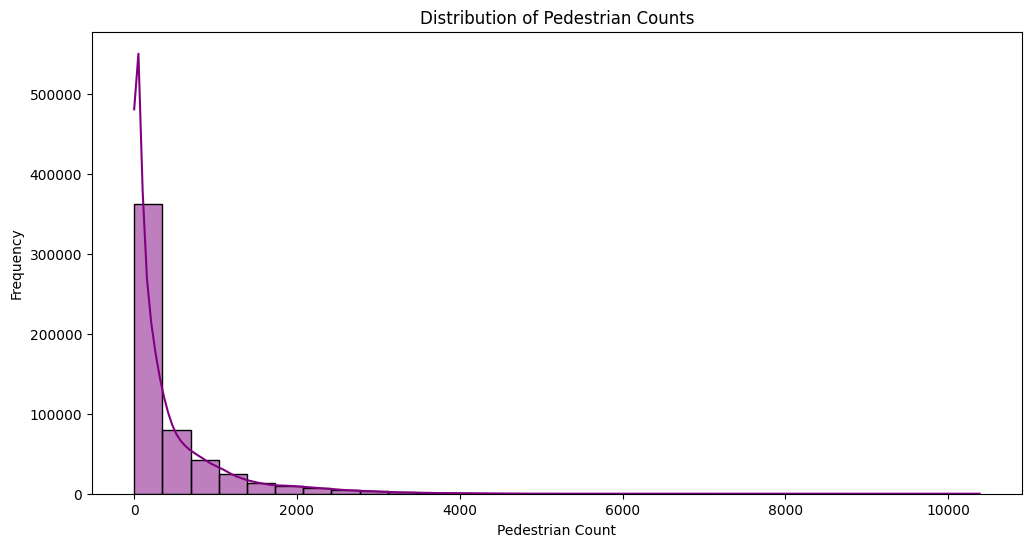

In [10]:
# Plot the distribution of pedestrian counts
plt.figure(figsize=(12, 6))
sns.histplot(ped['total_of_directions'], bins=30, kde=True, color='purple')
plt.title('Distribution of Pedestrian Counts')
plt.xlabel('Pedestrian Count')
plt.ylabel('Frequency')
plt.show()

The distribution of pedestrian counts shows how often each number of pedestrians is seen. This shows that very often less than two hundred pedestirnas were seen, with few days recording more than 2000 pedestrians. The highest pedestrian count is over 10,000.

Next an exploration of the temporal patterns in total numbers of pedestrians

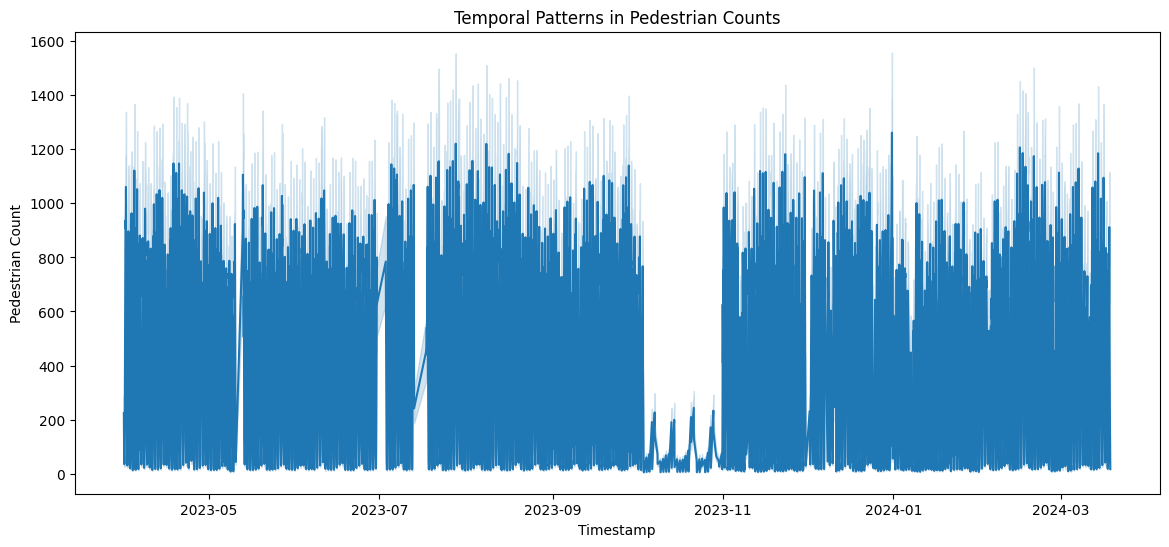

In [11]:
# Convert the timestamp column to datetime type data
ped['timestamp'] = pd.to_datetime(ped['timestamp'], utc=True)

# Plot temporal patterns in pedestrian counts
plt.figure(figsize=(14, 6))
sns.lineplot(x='timestamp', y='total_of_directions', data=ped)
plt.title('Temporal Patterns in Pedestrian Counts')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')
plt.show()


The Temporal pattern in pedestrian data illustrates pedestrian numbers per hour in the Melbourne area. There are obvious gaps in this data. From the checkss for null values above, there are no missing values in this dataset. This means theremust be dates missing where data has not been recorded. As this is the case, using dates for predicion modelling would not be effective.

A view of both the of locations of pedestrian counting and bus stop locations at the same time allows investgation of if there is overlap between these datasets.

In [12]:
# Extract latitude and longitude from Geo Shape
bus['coordinates'] = bus['geo_shape'].apply(lambda x: eval(x)['coordinates'])
bus[['Longitude', 'Latitude']] = pd.DataFrame(bus['coordinates'].tolist(), index=bus.index)

# Create a GeoDataFrame
gdf_bus = gpd.GeoDataFrame(bus, geometry=gpd.points_from_xy(bus['Latitude'], bus['Longitude']))
gdf_bus.head(3)

,geo_point_2d,geo_shape,addresspt1,asset_type,coordinates,Longitude,Latitude,geometry
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",76.819824,Sign - Public Transport,"[144.93239283833262, -37.80384165792465]",144.932393,-37.803842,POINT (-37.804 144.932)
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487,POINT (-37.815 144.958)
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539,POINT (-37.814 144.957)


In [13]:
# Split "Location" column into "Latitude" and "Longitude" for pedestrian counts
ped[['Latitude', 'Longitude']] = ped['location'].str.split(', ', expand=True).astype(float)
gdf_ped = gpd.GeoDataFrame(ped, geometry=gpd.points_from_xy(ped['Latitude'], ped['Longitude']))
gdf_ped.head(3)

,timestamp,locationid,direction_1,direction_2,total_of_directions,location,Latitude,Longitude,geometry
0,2023-04-24 21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661",-37.815153,144.974677,POINT (-37.815 144.975)
1,2023-04-25 00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661",-37.815153,144.974677,POINT (-37.815 144.975)
2,2023-04-25 01:00:00+00:00,75,63,63,126,"-37.81515276, 144.97467661",-37.815153,144.974677,POINT (-37.815 144.975)


In [14]:
# Reduce bus stop df to max and min of pedestrian count df
# Find total boundaries of lane df
minx, miny, maxx, maxy = gdf_ped.geometry.total_bounds
# Filter water by longitude max and min
df_filtered = gdf_bus[gdf_bus['Latitude'].between(minx-0.0001, maxx+0.0001)]
# Filter water by latutude max and min
gdf_bus_small = df_filtered[df_filtered['Longitude'].between(miny-0.0001, maxy+0.0001)]

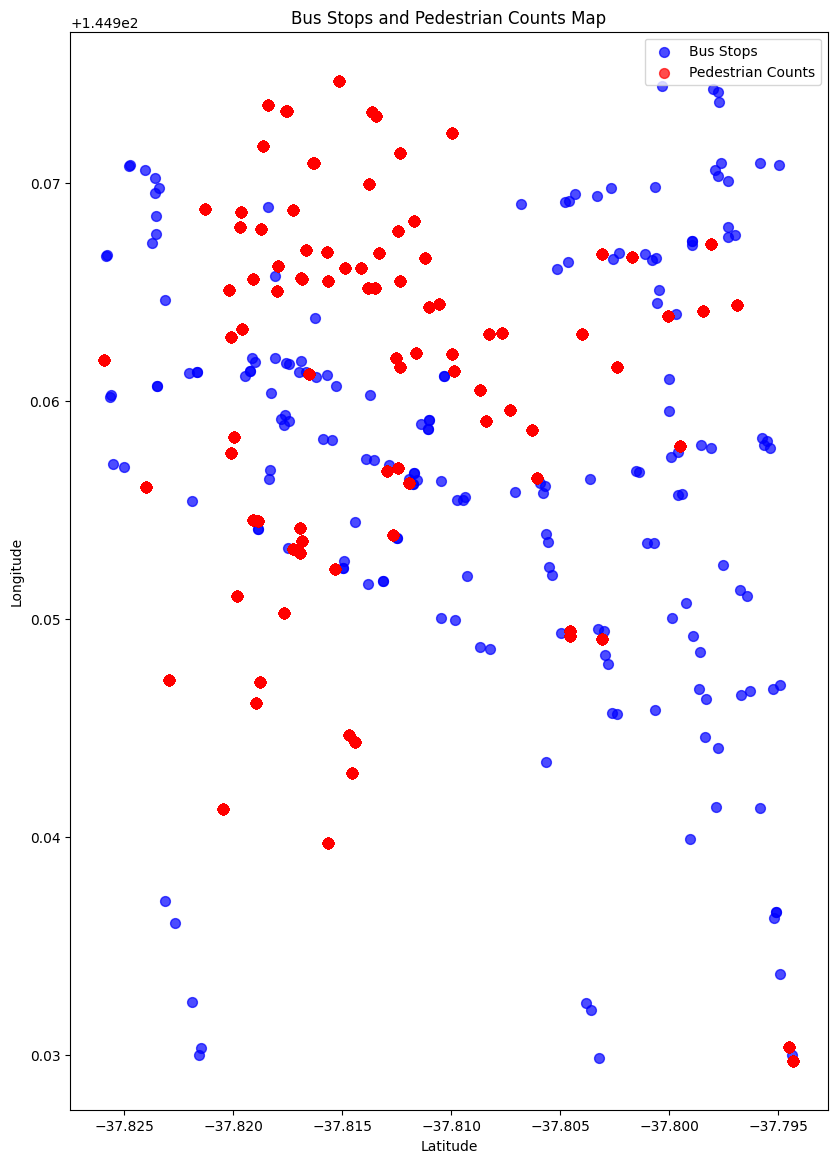

In [15]:
# Plotting locations of pedestrian counts and bus stops
fig, ax = plt.subplots(figsize=(14, 14))
gdf_bus_small.plot(ax=ax, color='blue', label='Bus Stops', markersize=50, alpha=0.7)
gdf_ped.plot(ax=ax, color='red', label='Pedestrian Counts', markersize=50, alpha=0.7)

# Customize the plot
ax.set_title('Bus Stops and Pedestrian Counts Map')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend()

plt.show()

This marker map shows the locations of bus stops and pedestrian count data. It can be seen that there are some locations where the pedestrian counting takes place near the bus stop locations. It would be useful to view the numbers of pedestrians where there are and where there are not bus stop locations. 

In [16]:
# select only the locations where there is overlap in the data, i.e. both pedestrian count and bus stop
import warnings
warnings.filterwarnings("ignore")
# Find rows from where the bus stops and pedestrian counts intersect
# Use sjoin_nearest method to do an inner join on bus stop small and ped
# Set the max_distance to allow for small discrepencies in locations
bus_ped_overlap_gdf = gdf_bus_small.sjoin_nearest(gdf_ped, max_distance=0.0003)
bus_ped_overlap_gdf = bus_ped_overlap_gdf[["Latitude_left","Longitude_left","geometry","timestamp","direction_1","direction_2","total_of_directions"]]
# Print length of dataframe to find number of laneways impacted by surface water flow
print(len(bus_ped_overlap_gdf))
bus_ped_overlap_gdf.head(2)

58274


,Latitude_left,Longitude_left,geometry,timestamp,direction_1,direction_2,total_of_directions
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-08-30 14:00:00+00:00,1,5,6
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-09-27 15:00:00+00:00,1,0,1


In [17]:
# add columne with value 1 for has bus stops to joined df
bus_ped = bus_ped_overlap_gdf.assign(bus_stop=1) 
# Rename columns to same as ped to allow for merge
bus_ped = bus_ped.rename(columns={"Latitude_left": "Latitude","Longitude_left":"Longitude"})
bus_ped.head(3)

# Print column names and data types
print("\033[1m\nData Types in Overlapping Bus Stop and Pedestrian Data:\033[0m")
print(bus_ped.dtypes)


Data Types in Overlapping Bus Stop and Pedestrian Data:
Latitude                           float64
Longitude                          float64
geometry                          geometry
timestamp              datetime64[ns, UTC]
direction_1                          int64
direction_2                          int64
total_of_directions                  int64
bus_stop                             int64
dtype: object


In [18]:
# Change ped dataframe to match bus_ped dataframe so they can be concatenated
# Select the required columns
merge_ped = gdf_ped[["Latitude","Longitude","geometry","timestamp","direction_1","direction_2","total_of_directions"]]
# Add bus stop column and set to default 0
merge_ped = merge_ped.assign(bus_stop=0) 
# Reanme timestamp column to date_time
merge_ped = merge_ped.rename(columns={"timestamp": "date_time"})
# Make new timestamp clumn and set as date time type
merge_ped['timestamp'] = pd.to_datetime(merge_ped['date_time'])
# Delete date_time column
merge_ped = merge_ped.drop(['date_time'], axis=1)
# Change order of columns to match bus_ped dataframe
merge_ped = merge_ped.iloc[:,[0,1,2,7,3,4,5,6]]

# Print column names and data types
print("\033[1m\nData Types in Pedestrian Data:\033[0m")
print(merge_ped.dtypes)


Data Types in Pedestrian Data:
Latitude                           float64
Longitude                          float64
geometry                          geometry
timestamp              datetime64[ns, UTC]
direction_1                          int64
direction_2                          int64
total_of_directions                  int64
bus_stop                             int64
dtype: object


In [19]:
# Concatenate dataframes
# List the dataframes to concatenate, with bus_ped first
frames = [bus_ped,merge_ped]
# Combine the dataframes with bus_ped at the top
many_bus_ped_all = pd.concat(frames)
# Print size and head of dataframe
print(many_bus_ped_all.shape)
many_bus_ped_all.head(2)

(608250, 8)


,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-08-30 14:00:00+00:00,1,5,6,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-09-27 15:00:00+00:00,1,0,1,1


In [20]:
# Delete rows with duplicate data in certain columns (all except bus stop), keeping first row
ped_busstops = many_bus_ped_all.drop_duplicates(subset=['Latitude', 'Longitude','geometry','direction_1','direction_2','total_of_directions','timestamp'],keep='first')
# Print size and head of dataframe
print(ped_busstops.shape)
ped_busstops.head(2)

(598119, 8)


,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-08-30 14:00:00+00:00,1,5,6,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-09-27 15:00:00+00:00,1,0,1,1


As there is a lot of data it would take a map a long time to load. To prevent this, the user is asked to input dates of interest (both start date and end date) to view the average number of pedestrians in each location during that time period.

In [21]:
# Select a date 
# Starting Timestamp
startingTimestamp = input("Please input the starting date in the form \"yyyy-mm-dd hh:mm:ss\"")

# Ending Timestamp
endingTimestamp = input("Please input the ending date in the form \"yyyy-mm-dd hh:mm:ss\"")

# Select rows where timestamp column is between values given
subDf = ped_busstops.loc[(ped_busstops[ 'timestamp'] > startingTimestamp) & (ped_busstops['timestamp'] <= endingTimestamp) ]
subDf.head(2)

,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-11-03 07:00:00+00:00,79,85,164,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-11-05 21:00:00+00:00,76,40,116,1


In [22]:
# select unique geometry with average total_of_directions
agg_df = subDf.groupby(['geometry','Latitude','Longitude','bus_stop'])['total_of_directions'].mean().round(0)

# Example 2: Convert groupby object to DataFrame 
grouped_df = agg_df.reset_index()
grouped_df.head(2)

,geometry,Latitude,Longitude,bus_stop,total_of_directions
0,POINT (-37.816 144.940),-37.815650,144.939707,0,100.0
1,POINT (-37.814 144.944),-37.814414,144.944330,0,155.0


In [23]:
# Split into two dataframes, one with bus stops and one without

grouped_with_stops = grouped_df[grouped_df['bus_stop'] == 1] 
gdf_grouped_with_stops = grouped_with_stops.set_geometry('geometry')
grouped_no_stops = grouped_df[grouped_df['bus_stop'] == 0] 
gdf_grouped_no_stops = grouped_no_stops.set_geometry('geometry')

In [24]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add pedestrian numbers at locations without bus stops
for i in range(0,len(grouped_no_stops)):
   folium.Marker(
      location=[grouped_no_stops.iloc[i]['Latitude'], grouped_no_stops.iloc[i]['Longitude']],
      popup=grouped_no_stops.iloc[i]['total_of_directions'],
      icon=folium.Icon(color="green"),
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(grouped_with_stops)):
   folium.Marker(
      location=[grouped_with_stops.iloc[i]['Latitude'], grouped_with_stops.iloc[i]['Longitude']],
      popup=grouped_with_stops.iloc[i]['total_of_directions'],
      icon=folium.Icon(color="pink"),
   ).add_to(m)

# Show the map
m

The interactive street map above shows markers in green and pink. Green represents places of pedestrian counts where there are not bus stops. Pink represents the places where there are bus stops. By clicking on the information icon, the average number of pedestrians in the time period specified can be viewed.

PREDICTIVE ANALYSIS

To detemine if there are relationships between numbers of pedestrians and bus stop locations, further analysis will need to take place. From the map above, there are many more locations withou bus stops than with bus stops. This assumption needs to be verified as it impacts sampling for predictive models.

In [25]:
# Selection of columns for a dataframe that will be used for predicitive analysis
relations = ped_busstops[['bus_stop','direction_1','direction_2','total_of_directions']]

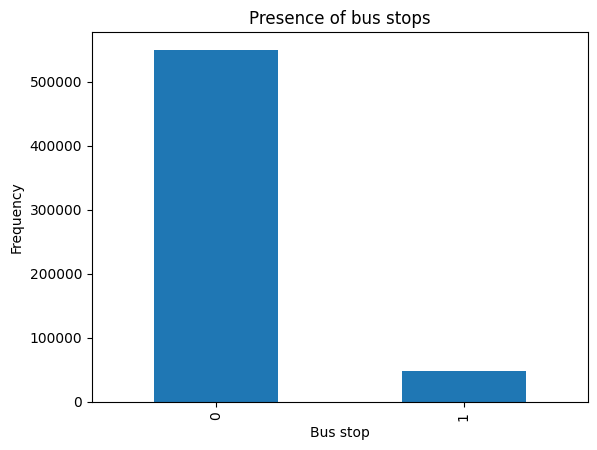

In [26]:
# Graph of bus stop classes in relationship table
relations['bus_stop'].value_counts().plot(kind='bar')
plt.xlabel('Bus stop')
plt.ylabel('Frequency')
plt.title('Presence of bus stops')
plt.show()

In [29]:
# Count number of each value in bus_stop column
relations['bus_stop'].value_counts()

bus_stop
0    549915
1     48204
Name: count, dtype: int64

The column graph and count output shows that there are many more values in the dataset without bus stops (0) than with bus stops (1). This means that if prediction modelling takes place on the current dataset, the no bus stops will be over represented and the model will be bias. To correct for this imbalance, resampling will need to take place prior to prediction modelling or a bagging method will need to be used.

In [27]:
# Apply z-score standardisation to all columns except bus stop
relations.update(relations.drop(columns=["bus_stop"]).apply(zscore))
relations.head(3)

,bus_stop,direction_1,direction_2,total_of_directions
5,1,-0.641895,-0.631974,-0.669664
5,1,-0.641895,-0.647913,-0.678027
5,1,-0.578381,-0.600097,-0.619487


Method One: Undersampling the no bus stops data

In [30]:
# Undersampling no bus stop data
# Shuffle the relations dataset
shuffled_df = relations.sample(frac=1,random_state=42)

# Put all of the observations with bus stops in one dataframe.
stop_df = shuffled_df.loc[shuffled_df['bus_stop'] == 1]

# Randomly select 48204 observations from the no bus stops data and place in a dataframe
no_stop_df = shuffled_df.loc[shuffled_df['bus_stop'] == 0].sample(n=48204,random_state=42)

# Concatenate both dataframes again
undersampled_relations = pd.concat([stop_df, no_stop_df])
# Check the new sampled dataframe has the correct number of rows
undersampled_relations.shape

(96408, 4)

In [34]:
# Logistic Regression with undersampling
# Set the x and y variables. x = all variables except bus stop, y = bus stop
X = undersampled_relations.drop(["bus_stop"], axis=1)
y = undersampled_relations["bus_stop"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify = undersampled_relations['bus_stop'])

# Initiate Logistic Regression
lr_model = LogisticRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 57.02%
Confusion Matrix:
 [[ 5381  9081]
 [ 3350 11111]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.37      0.46     14462
           1       0.55      0.77      0.64     14461

    accuracy                           0.57     28923
   macro avg       0.58      0.57      0.55     28923
weighted avg       0.58      0.57      0.55     28923



Undersampling creates a dataframe with an equal number of rows with and without a bus stop. This is done by first taking all of the rows with bus stops out of the dataset. Then the remaining non bus stop rows are shuffled and a sample of the same number as bus stop rows is selected. This sample is then added to the bus stop data making a new dataframe.</br>
 Logistic regression prediction is used to determine the relationship between pedestrian numbers and bus stops as the bus stop variable is binary. The accuracy score function compares the predicted value to the target values. At only 57% of the time the logistic regression model with undersampled data can accurately state if there is not a bus stop based on the number of pedestrians. This means that the model is not working very well. This model inaccuracy is echoed in the precision, f1 scores and recall reported by the classification report. The confusion matrix tells us that this models is making many false postive predictions; i.e stating that there is a bus stop when there is no bus stop. 

The first logistic regression model using undersampling suggests that pedestrian numbers cannot be used as a predictor for bus stop locations, i.e that there is not a strong relationship between these variables. However, as poor modelling may caused by having a small data set, a second approach of oversampling the bus stop data will be also investigated.

Method Two: Oversampling bus stop data

In [37]:
# Initiate SMOTE to resample data
sm = SMOTE(random_state=42)


In [40]:
# Set the x and y variables from the whole dataset
X = relations.drop(["bus_stop"], axis=1)
y = relations["bus_stop"]

# Use SMOTE resampling n data
X, y = sm.fit_resample(X, y)

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Initiate Logistic Regression
lr_model = LogisticRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 57.07%
Confusion Matrix:
 [[ 61506 103645]
 [ 38013 126785]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.37      0.46    165151
           1       0.55      0.77      0.64    164798

    accuracy                           0.57    329949
   macro avg       0.58      0.57      0.55    329949
weighted avg       0.58      0.57      0.55    329949



Oversampling also creates a dataframe with an equal number of rows with and without a bus stop. This is done using the SMOTE. With the defaut parameter settings, SMOTE creates a transformed version of the dataset that balanaces the minority bus stops class.This is seen in the support column of the classification table, with almost equal values of bus stop and non-bus stop data.</br>
In logistic regression with oversampled data, the accuracy score remains unchanged at only 57%. This means once again that the model is not working very well. This model inaccuracy is echoed in the precision, f1 scores and recall reported by the classification report. The confusion matrix tells us that this model with oversampled data is also making many false postive predictions.

As both undersampling and over sampling are giving poor results, a predictive model that incorporates bootstrapping may be more suited to determining if there is a relationship between pedestrian numbers and the presence of a bus stop.

In [51]:
# Set the x and y variables from the whole dataset
X = relations.drop(["bus_stop"], axis=1)
y = relations["bus_stop"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Create a Random Forest classifier with Bootstrap class weighting
rf_bcw = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
 
# Train the Random Forest classifier on the training data
rf_bcw.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = rf_bcw.predict(X_test)
 
# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 69.79%
Confusion Matrix:
 [[119139  45823]
 [  8384   6090]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.72      0.81    164962
           1       0.12      0.42      0.18     14474

    accuracy                           0.70    179436
   macro avg       0.53      0.57      0.50    179436
weighted avg       0.87      0.70      0.76    179436



The Random Forest classifier parameter class weighting is used to address imbalance in datasets without needing to resample data outside of a predictive model. Setting this parameter to balanced subsample means that in prediction modelling more weight is given to the samples where there is a bus stop.</br>
In the Random Forest classification model, the accuracy score is still low, reaching just under 70%. While the precision of identifying where there were no bus stops increased, the precision of identifying a bus stop decreased significantly compared to that of Logistic regression models. The Random Forest classification also reports many more false negatives (i.e. reports that there are many fewer bus stop locations than there really are) compared to the two logistic methods investigated above. While accuracy of this model performed better than the logstic regression models, it is still evident that predictions cannot be made on the presence of a bus stop using the data availibe.

This use case aimed to determine if there were strong relationships between pedestrian numbers and bus stop locations. The main difficulty acssociated with this investigation was that there were few locations of overlap where bus stops and pedestrian counting occurred. Many places of pedestrain counting did not have a bus stop associated, thus making the dataset unequal in size of bus stop vs non-bus stop locations. To address this imbalance, methods of oversmapling, undersampling and bootstrapping where appied to predictive modelling to determine if there was a relationship between the variables. All predictive models tested had results that do not suggest a strong relationship between pedestrian numbers and bus stop locations.

##### References

<fn id="fn-1">[1]</fn> Melbourne City Council (2023) [Pedestrian Counting System - City of Melbourne](https://www.melbourne.vic.gov.au/about-melbourne/research-and-statistics/city-population/Pages/pedestrian-counting-system.aspx). City of Melbourne Council, Australia. 


# from here to fix
<fn id="fn-2">[2]</fn> Trees for Cities (2023) [Trees in our Cities: 10 Reasons we need to plant more](https://www.treesforcities.org/stories/trees-in-our-cities-10-reasons-we-need-to-plant-more). Trees for Cities Organisation, England. 

<fn id="fn-3">[3]</fn> Institute of Chartered Foresters (2017) [Trees can reduce floods](https://www.charteredforesters.org/trees-can-reduce-floods) Institute of Chartered Foresters Organisation, England.

<fn id="fn-4">[4]</fn> Vistoria State of Emergency Service (2021) [Melbourne CBD
Local Flood Guide - Flash Flood information for Melbourne CBD](https://www.ses.vic.gov.au/documents/8655930/9320133/Melbourne+CBD+-+LFG+-+Draft+1.3.pdf/10235674-fc8e-8515-f167-a1cb7f7a4531?version=1.0&t=1634863369470h). City of Melbourne Council, Australia.
